### Setup environment

In [ ]:

!pip install mediapy einops --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
import torch
import mediapy as media
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from scipy.linalg import sqrtm
from sklearn.metrics.pairwise import polynomial_kernel
from torchvision.models import inception_v3
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.nn.functional import adaptive_avg_pool2d
from scipy.stats import entropy


## CIFAR-10 model

### Import diffusion model

In [ ]:
from diffusers import DDPMPipeline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

pipeline = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32").to(device)
unet = pipeline.unet
scheduler = pipeline.scheduler


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/143M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Normalize, Compose
from diffusers import DDPMPipeline

# --- Load pipeline ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32").to(device)
pipeline.set_progress_bar_config(disable=False)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


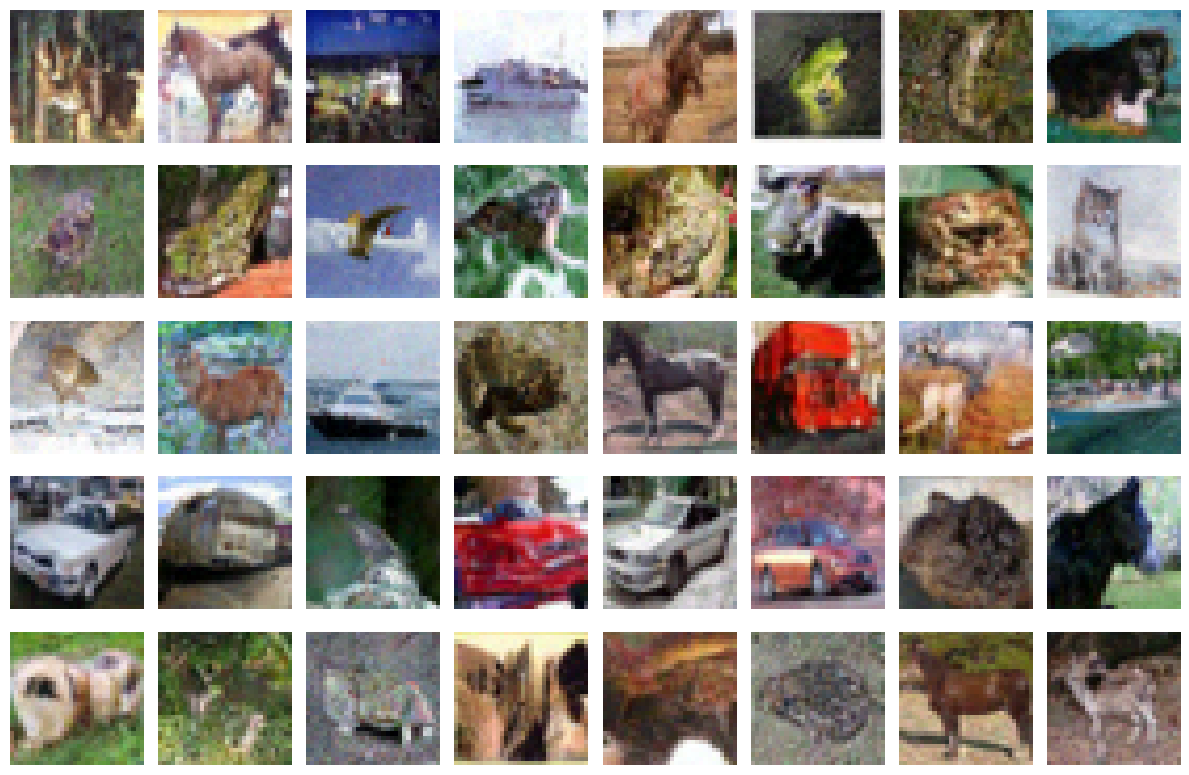

In [ ]:
import matplotlib.pyplot as plt

@torch.no_grad()
def sample_ddpm(unet, scheduler, num_images=40, img_size=(3, 32, 32), num_timesteps=250):
    unet.eval()
    scheduler.set_timesteps(num_timesteps)
    x_t = torch.randn((num_images, *img_size), device=device)

    for t in scheduler.timesteps:
        model_output = unet(x_t, t).sample
        x_t = scheduler.step(model_output, t, x_t).prev_sample

    return x_t

unet = pipeline.unet
scheduler = pipeline.scheduler

samples = sample_ddpm(unet, scheduler, num_images=40)

samples = (samples.clamp(-1, 1) + 1) / 2
samples = samples.cpu()

fig, axs = plt.subplots(5, 8, figsize=(12, 8))
for i, ax in enumerate(axs.flatten()):
    img = samples[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

from torchvision.datasets import CIFAR10
transform = Compose([
    Resize((32, 32)),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)


100%|██████████| 170M/170M [01:38<00:00, 1.74MB/s]


### Import discriminator and test it on original diffusion model

In [ ]:
import torch
import torch.nn as nn
import urllib.request

class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# --- Download the pretrained weights ---
url = "https://github.com/csinva/gan-vae-pretrained-pytorch/raw/master/cifar10_dcgan/weights/netD_epoch_199.pth"
torch.hub.download_url_to_file(url, 'netD_epoch_199.pth')

# --- Load model and weights ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netD = Discriminator(ngpu=1).to(device)
netD.load_state_dict(torch.load('netD_epoch_199.pth', map_location=device))
netD.eval()


100%|██████████| 10.5M/10.5M [00:00<00:00, 502MB/s]


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
from torchvision.transforms import ToTensor, Compose
import torch
from torchvision.transforms import Normalize
from diffusers import DDPMPipeline
from torch.utils.data import DataLoader
import torch.nn as nn

transform = Compose([
    Resize((32,32)),
    ToTensor(),
    Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

pipeline = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32").to(device)
pipeline.set_progress_bar_config(disable=False)

generated = pipeline(num_inference_steps=250, batch_size=250).images

imgs_tensor = torch.stack([transform(img) for img in generated]).to(device)

with torch.no_grad():
    scores = netD(imgs_tensor)

print(f'Mean discriminator score on 250 generated CIFAR-10 images: {scores.mean().item():.4f}')

dataset   = CIFAR10(root="./data", train=True, download=True, transform=transform)
loader    = DataLoader(dataset, batch_size=250, shuffle=True, num_workers=4)

all_outputs = []
images_seen = 0
with torch.no_grad():
    for images, _ in loader:
        images = images.to(device)
        output = netD(images)  # Shape: (batch_size,)
        all_outputs.append(output.cpu())
        images_seen += images.size(0)
        if images_seen >= 250:
            break

# Stack and truncate to exactly 250
outputs = torch.cat(all_outputs)[:250]

mean_score = outputs.mean().item()
print(f"Mean discriminator score on 250 real CIFAR-10 images: {mean_score:.4f}")

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/250 [00:00<?, ?it/s]

Mean discriminator score on 250 generated CIFAR-10 images: 0.2374
Mean discriminator score on 250 real CIFAR-10 images: 0.4169


### Plot original images

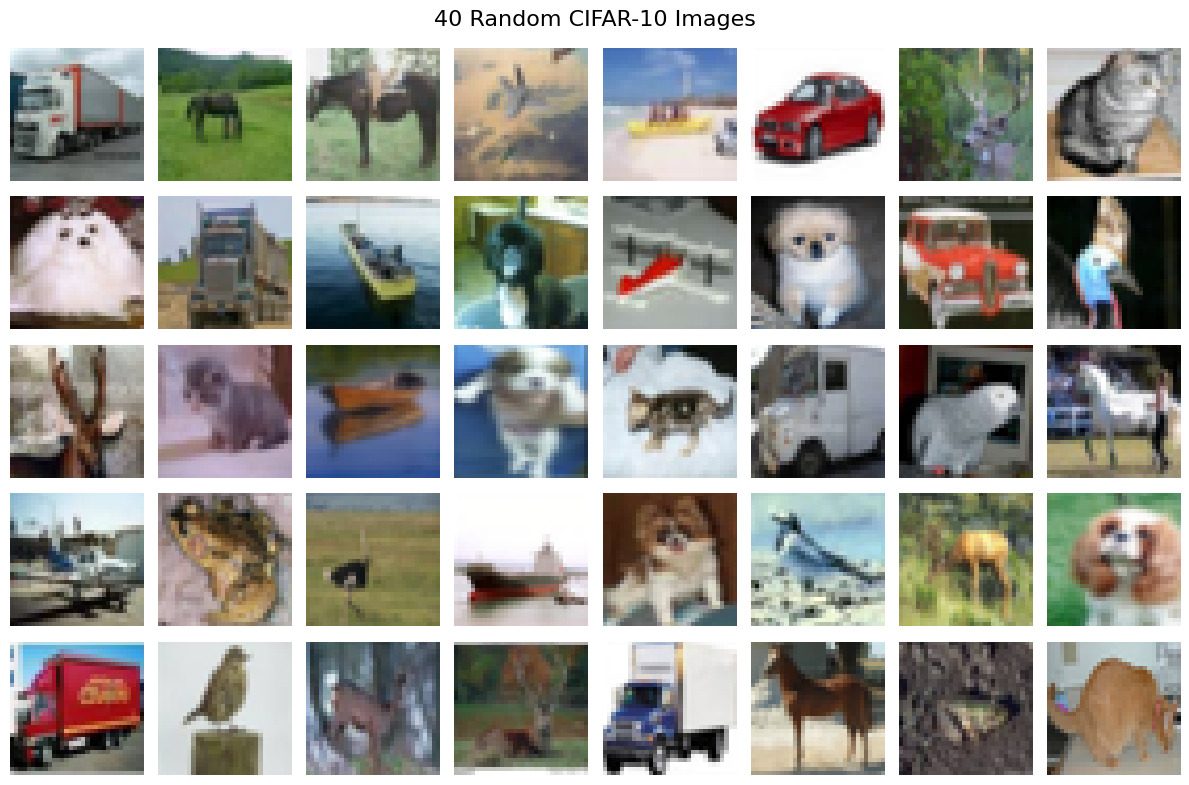

In [ ]:
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

transform = ToTensor()
dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=40, shuffle=True)
images, labels = next(iter(loader))

plt.figure(figsize=(12, 8))
for i in range(40):
    plt.subplot(5, 8, i + 1)
    img = images[i].permute(1, 2, 0)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("40 Random CIFAR-10 Images", fontsize=16)
plt.tight_layout()
plt.show()


### Fine-tune the diffusion model and train discriminator from scratch on noise

In [ ]:
from diffusers import DDPMPipeline
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline      = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32").to(device)
unet          = pipeline.unet
scheduler     = pipeline.scheduler
discriminator = Discriminator(ngpu=1, nc=3, ndf=64).to(device)
discriminator.apply(weights_init)

lr_d = 1e-4
lr_g = 1e-5
batch_size = 512
epochs = 20

optD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5,0.999))
optG = optim.Adam(unet.parameters(),         lr=lr_g, betas=(0.5,0.999))
bce  = nn.BCELoss()

transform = Compose([
    Resize((32,32)),
    ToTensor(),
    Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
dataset   = CIFAR10(root="./data", train=True, download=True, transform=transform)
loader    = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

for epoch in range(epochs):
    i = 0
    for imgs, _ in loader:
        i += 1
        imgs = imgs.to(device)

        t = torch.randint(0, scheduler.num_train_timesteps,
                          (imgs.size(0),), device=device)

        alpha_bar = scheduler.alphas_cumprod.to(device)[t].view(-1,1,1,1)
        sqrt_ab    = alpha_bar.sqrt()
        sqrt_1_ab  = (1 - alpha_bar).sqrt()
        noise      = torch.randn_like(imgs)
        x_t        = sqrt_ab * imgs + sqrt_1_ab * noise

        for p in unet.parameters():        p.requires_grad_(False)
        for p in discriminator.parameters(): p.requires_grad_(True)
        discriminator.train(); unet.eval()

        with torch.no_grad():
            eps_pred = unet(sample=x_t, timestep=t).sample

        real_scores = discriminator(noise)
        fake_scores = discriminator(eps_pred)
        lossD = bce(real_scores, torch.ones_like(real_scores)) + \
                bce(fake_scores, torch.zeros_like(fake_scores))

        optD.zero_grad(); lossD.backward(); optD.step()
        if (i % 10) == 0:
          print(f"real scores: {real_scores.mean().item():.4f}, fake scores: {fake_scores.mean().item():.4f}")

        if epoch > 1:
            for p in unet.parameters():        p.requires_grad_(True)
            for p in discriminator.parameters(): p.requires_grad_(False)
            unet.train(); discriminator.train()

            eps_pred = unet(sample=x_t, timestep=t).sample
            gen_scores = discriminator(eps_pred)
            lossG = bce(gen_scores, torch.ones_like(gen_scores))

            optG.zero_grad(); lossG.backward(); optG.step()
            if (i % 10) == 0:
              print (i)
              print(f"Fake scores from generator after disc update: {gen_scores.mean().item():.4f}")


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


NameError: name 'Discriminator' is not defined

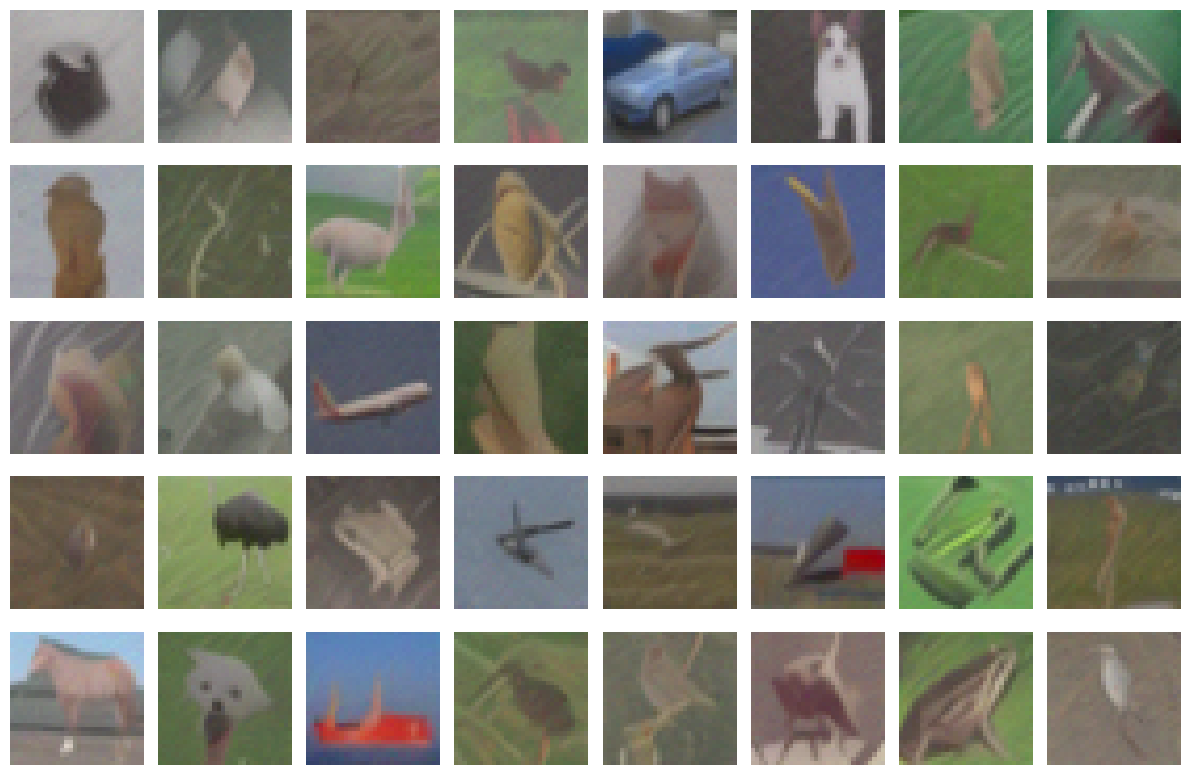

In [ ]:
import matplotlib.pyplot as plt

@torch.no_grad()
def sample_ddpm(unet, scheduler, num_images=40, img_size=(3, 32, 32), num_timesteps=250):
    unet.eval()
    scheduler.set_timesteps(num_timesteps)
    x_t = torch.randn((num_images, *img_size), device=device)

    for t in scheduler.timesteps:
        model_output = unet(x_t, t).sample
        x_t = scheduler.step(model_output, t, x_t).prev_sample

    return x_t

samples = sample_ddpm(unet, scheduler, num_images=40)

samples = (samples.clamp(-1, 1) + 1) / 2
samples = samples.cpu()

fig, axs = plt.subplots(5, 8, figsize=(12, 8))
for i, ax in enumerate(axs.flatten()):
    img = samples[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
from torchvision.transforms import ToTensor, Compose
import torch
from torchvision.transforms import Normalize
from diffusers import DDPMPipeline
from torch.utils.data import DataLoader
import torch.nn as nn

transform = Compose([
    Resize((32,32)),
    ToTensor(),
    Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

samples = sample_ddpm(unet, scheduler, num_images=40)

samples = (samples.clamp(-1, 1))
samples = samples.to(device)

with torch.no_grad():
    scores = netD(samples)

print(f'Mean discriminator score on 250 generated CIFAR-10 images: {scores.mean().item():.4f}')

dataset   = CIFAR10(root="./data", train=True, download=True, transform=transform)
loader    = DataLoader(dataset, batch_size=250, shuffle=True, num_workers=4)

all_outputs = []
images_seen = 0
with torch.no_grad():
    for images, _ in loader:
        images = images.to(device)
        output = netD(images)  # Shape: (batch_size,)
        all_outputs.append(output.cpu())
        images_seen += images.size(0)
        if images_seen >= 250:
            break

# Stack and truncate to exactly 250
outputs = torch.cat(all_outputs)[:250]

mean_score = outputs.mean().item()
print(f"Mean discriminator score on 250 real CIFAR-10 images: {mean_score:.4f}")

Mean discriminator score on 250 generated CIFAR-10 images: 0.0829
Mean discriminator score on 250 real CIFAR-10 images: 0.4931


In [ ]:
torch.save(unet.state_dict(), "diffusion_CIFAR10_20_epochs.pth")
from google.colab import files
files.download("diffusion_CIFAR10_20_epochs.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Fine-tune the diffusion model, same technique but different hyperparams

In [ ]:
def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [ ]:
from diffusers import DDPMPipeline
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline      = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32").to(device)
unet          = pipeline.unet
scheduler     = pipeline.scheduler
discriminator = Discriminator(ngpu=1, nc=3, ndf=64).to(device)
discriminator.apply(weights_init)

lr_d = 1e-4
lr_g = 1e-5
batch_size = 128
epochs = 5

optD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5,0.999))
optG = optim.Adam(unet.parameters(),         lr=lr_g, betas=(0.5,0.999))
bce  = nn.BCELoss()
mse = nn.MSELoss()

transform = Compose([
    Resize((32,32)),
    ToTensor(),
    Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
dataset   = CIFAR10(root="./data", train=True, download=True, transform=transform)
loader    = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

for epoch in range(epochs):
    i = 0
    for imgs, _ in loader:
        i += 1
        imgs = imgs.to(device)

        t = torch.randint(0, scheduler.num_train_timesteps,
                          (imgs.size(0),), device=device)

        alpha_bar = scheduler.alphas_cumprod.to(device)[t].view(-1,1,1,1)
        sqrt_ab    = alpha_bar.sqrt()
        sqrt_1_ab  = (1 - alpha_bar).sqrt()
        noise      = torch.randn_like(imgs)
        x_t        = sqrt_ab * imgs + sqrt_1_ab * noise

        for p in unet.parameters():        p.requires_grad_(False)
        for p in discriminator.parameters(): p.requires_grad_(True)
        discriminator.train(); unet.eval()

        with torch.no_grad():
            eps_pred = unet(sample=x_t, timestep=t).sample

        real_scores = discriminator(noise)
        fake_scores = discriminator(eps_pred)
        lossD = mse(real_scores, torch.ones_like(real_scores)) + \
                mse(fake_scores, torch.zeros_like(fake_scores))

        optD.zero_grad(); lossD.backward(); optD.step()
        if (i % 10) == 0:
          print(i)
          print(f"real scores: {real_scores.mean().item():.4f}, fake scores: {fake_scores.mean().item():.4f}")

        if epoch > 1:
            for p in unet.parameters():        p.requires_grad_(True)
            for p in discriminator.parameters(): p.requires_grad_(False)
            unet.train(); discriminator.train()

            eps_pred = unet(sample=x_t, timestep=t).sample
            gen_scores = discriminator(eps_pred)
            lossG = mse(gen_scores, torch.ones_like(gen_scores))

            optG.zero_grad(); lossG.backward(); optG.step()
            if (i % 10) == 0:
              print (i)
              print(f"Fake scores from generator after disc update: {gen_scores.mean().item():.4f}")


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


10
real scores: 0.4993, fake scores: 0.4964
20
real scores: 0.4636, fake scores: 0.4606
30
real scores: 0.4777, fake scores: 0.4808
40
real scores: 0.5443, fake scores: 0.5414
50
real scores: 0.5621, fake scores: 0.5575
60
real scores: 0.4573, fake scores: 0.4546
70
real scores: 0.4839, fake scores: 0.4814
80
real scores: 0.4993, fake scores: 0.4963
90
real scores: 0.4783, fake scores: 0.4756
100
real scores: 0.5207, fake scores: 0.5143
110
real scores: 0.4997, fake scores: 0.4947
120
real scores: 0.5353, fake scores: 0.5330
130
real scores: 0.5017, fake scores: 0.4986
140
real scores: 0.4775, fake scores: 0.4760
150
real scores: 0.4371, fake scores: 0.4307
160
real scores: 0.5051, fake scores: 0.4984
170
real scores: 0.5364, fake scores: 0.5333
180
real scores: 0.5291, fake scores: 0.5201
190
real scores: 0.5248, fake scores: 0.5192
200
real scores: 0.5408, fake scores: 0.5340
210
real scores: 0.4991, fake scores: 0.4913
220
real scores: 0.4648, fake scores: 0.4573
230
real scores: 0.

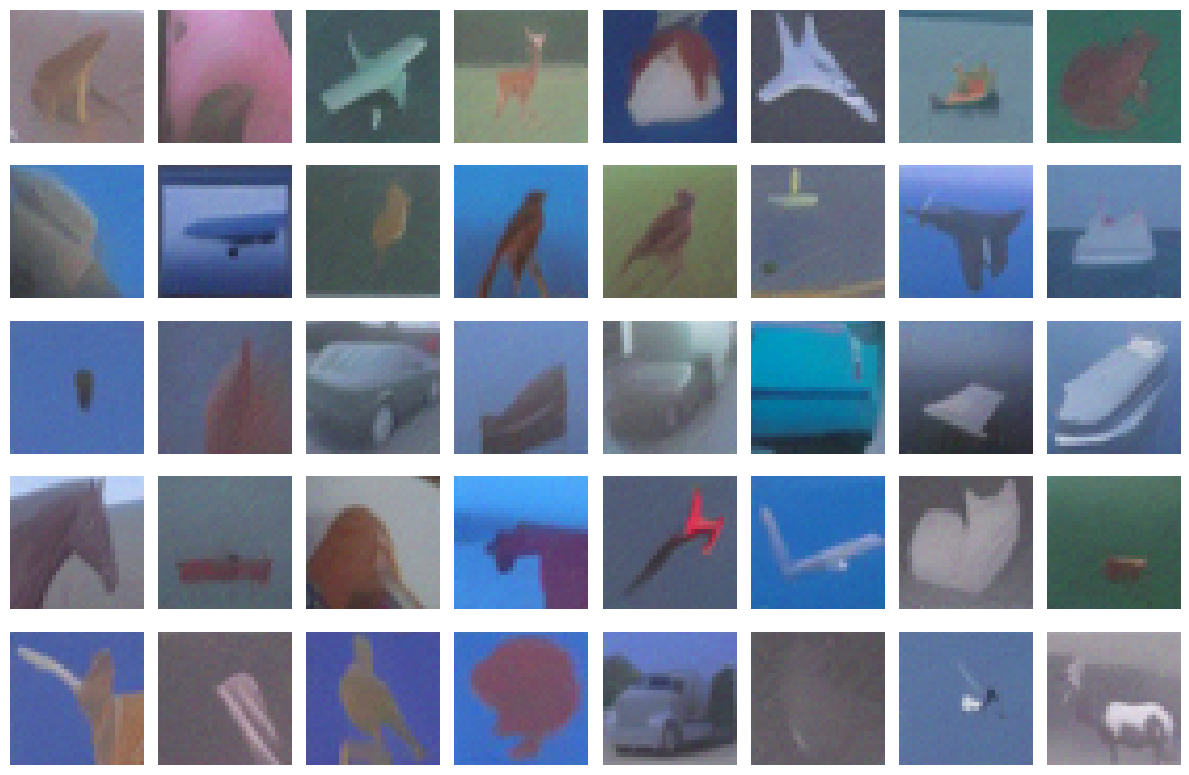

In [ ]:
import matplotlib.pyplot as plt

@torch.no_grad()
def sample_ddpm(unet, scheduler, num_images=40, img_size=(3, 32, 32), num_timesteps=250):
    unet.eval()
    scheduler.set_timesteps(num_timesteps)
    x_t = torch.randn((num_images, *img_size), device=device)

    for t in scheduler.timesteps:
        model_output = unet(x_t, t).sample
        x_t = scheduler.step(model_output, t, x_t).prev_sample

    return x_t

samples = sample_ddpm(unet, scheduler, num_images=40)

samples = (samples.clamp(-1, 1) + 1) / 2
samples = samples.cpu()

fig, axs = plt.subplots(5, 8, figsize=(12, 8))
for i, ax in enumerate(axs.flatten()):
    img = samples[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage

transform = Compose([
    Resize((32, 32)),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

to_pil = ToPILImage()

num_eval = 250
samples = sample_ddpm(unet, scheduler, num_images=num_eval)  # in [-1, 1]

# Convert to list of transformed tensors
transformed_samples = []
for img in samples:
    img = (img.cpu().clamp(-1, 1) + 1) / 2  # [-1,1] -> [0,1]
    pil = to_pil(img)
    transformed = transform(pil)  # runs Resize + ToTensor + Normalize
    transformed_samples.append(transformed)

# Stack to batch
batch = torch.stack(transformed_samples).to(device)

# Score with discriminator
netD.eval()
with torch.no_grad():
    scores = netD(batch)  # shape: [250]

avg_score = scores.mean().item()
print(f"Average D(realness) over {num_eval} samples: {avg_score:.4f}")


Average D(realness) over 250 samples: 0.0930


### Train a discriminator on noisy images with time condition. Use both discriminator feedback and diffusion feedback during sampling.

In [ ]:
from diffusers import DDPMPipeline
import numpy as np

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
pipeline = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32").to(device)

# First we need to generate 50000 fake images
@torch.no_grad()
def generate_fake_images(pipeline, num_samples, batch_size=128):
    samples = []
    for i in range(0, num_samples, batch_size):
        print(i)
        b = min(batch_size, num_samples - i)
        out = pipeline(num_inference_steps=100, batch_size=b).images
        imgs = torch.tensor(
            np.stack([np.array(im).transpose(2, 0, 1) for im in out]) / 255.0,
            dtype=torch.float32,
        )
        samples.append(imgs)
    return torch.cat(samples)

fake_images = generate_fake_images(pipeline, num_samples=50000)
torch.save(fake_images, "fake_images_cifar_50k.pt")


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


0


  0%|          | 0/100 [00:00<?, ?it/s]

128


  0%|          | 0/100 [00:00<?, ?it/s]

256


  0%|          | 0/100 [00:00<?, ?it/s]

384


  0%|          | 0/100 [00:00<?, ?it/s]

512


  0%|          | 0/100 [00:00<?, ?it/s]

640


  0%|          | 0/100 [00:00<?, ?it/s]

768


  0%|          | 0/100 [00:00<?, ?it/s]

896


  0%|          | 0/100 [00:00<?, ?it/s]

1024


  0%|          | 0/100 [00:00<?, ?it/s]

1152


  0%|          | 0/100 [00:00<?, ?it/s]

1280


  0%|          | 0/100 [00:00<?, ?it/s]

1408


  0%|          | 0/100 [00:00<?, ?it/s]

1536


  0%|          | 0/100 [00:00<?, ?it/s]

1664


  0%|          | 0/100 [00:00<?, ?it/s]

1792


  0%|          | 0/100 [00:00<?, ?it/s]

1920


  0%|          | 0/100 [00:00<?, ?it/s]

2048


  0%|          | 0/100 [00:00<?, ?it/s]

2176


  0%|          | 0/100 [00:00<?, ?it/s]

2304


  0%|          | 0/100 [00:00<?, ?it/s]

2432


  0%|          | 0/100 [00:00<?, ?it/s]

2560


  0%|          | 0/100 [00:00<?, ?it/s]

2688


  0%|          | 0/100 [00:00<?, ?it/s]

2816


  0%|          | 0/100 [00:00<?, ?it/s]

2944


  0%|          | 0/100 [00:00<?, ?it/s]

3072


  0%|          | 0/100 [00:00<?, ?it/s]

3200


  0%|          | 0/100 [00:00<?, ?it/s]

3328


  0%|          | 0/100 [00:00<?, ?it/s]

3456


  0%|          | 0/100 [00:00<?, ?it/s]

3584


  0%|          | 0/100 [00:00<?, ?it/s]

3712


  0%|          | 0/100 [00:00<?, ?it/s]

3840


  0%|          | 0/100 [00:00<?, ?it/s]

3968


  0%|          | 0/100 [00:00<?, ?it/s]

4096


  0%|          | 0/100 [00:00<?, ?it/s]

4224


  0%|          | 0/100 [00:00<?, ?it/s]

4352


  0%|          | 0/100 [00:00<?, ?it/s]

4480


  0%|          | 0/100 [00:00<?, ?it/s]

4608


  0%|          | 0/100 [00:00<?, ?it/s]

4736


  0%|          | 0/100 [00:00<?, ?it/s]

4864


  0%|          | 0/100 [00:00<?, ?it/s]

4992


  0%|          | 0/100 [00:00<?, ?it/s]

5120


  0%|          | 0/100 [00:00<?, ?it/s]

5248


  0%|          | 0/100 [00:00<?, ?it/s]

5376


  0%|          | 0/100 [00:00<?, ?it/s]

5504


  0%|          | 0/100 [00:00<?, ?it/s]

5632


  0%|          | 0/100 [00:00<?, ?it/s]

5760


  0%|          | 0/100 [00:00<?, ?it/s]

5888


  0%|          | 0/100 [00:00<?, ?it/s]

6016


  0%|          | 0/100 [00:00<?, ?it/s]

6144


  0%|          | 0/100 [00:00<?, ?it/s]

6272


  0%|          | 0/100 [00:00<?, ?it/s]

6400


  0%|          | 0/100 [00:00<?, ?it/s]

6528


  0%|          | 0/100 [00:00<?, ?it/s]

6656


  0%|          | 0/100 [00:00<?, ?it/s]

6784


  0%|          | 0/100 [00:00<?, ?it/s]

6912


  0%|          | 0/100 [00:00<?, ?it/s]

7040


  0%|          | 0/100 [00:00<?, ?it/s]

7168


  0%|          | 0/100 [00:00<?, ?it/s]

7296


  0%|          | 0/100 [00:00<?, ?it/s]

7424


  0%|          | 0/100 [00:00<?, ?it/s]

7552


  0%|          | 0/100 [00:00<?, ?it/s]

7680


  0%|          | 0/100 [00:00<?, ?it/s]

7808


  0%|          | 0/100 [00:00<?, ?it/s]

7936


  0%|          | 0/100 [00:00<?, ?it/s]

8064


  0%|          | 0/100 [00:00<?, ?it/s]

8192


  0%|          | 0/100 [00:00<?, ?it/s]

8320


  0%|          | 0/100 [00:00<?, ?it/s]

8448


  0%|          | 0/100 [00:00<?, ?it/s]

8576


  0%|          | 0/100 [00:00<?, ?it/s]

8704


  0%|          | 0/100 [00:00<?, ?it/s]

8832


  0%|          | 0/100 [00:00<?, ?it/s]

8960


  0%|          | 0/100 [00:00<?, ?it/s]

9088


  0%|          | 0/100 [00:00<?, ?it/s]

9216


  0%|          | 0/100 [00:00<?, ?it/s]

9344


  0%|          | 0/100 [00:00<?, ?it/s]

9472


  0%|          | 0/100 [00:00<?, ?it/s]

9600


  0%|          | 0/100 [00:00<?, ?it/s]

9728


  0%|          | 0/100 [00:00<?, ?it/s]

9856


  0%|          | 0/100 [00:00<?, ?it/s]

9984


  0%|          | 0/100 [00:00<?, ?it/s]

10112


  0%|          | 0/100 [00:00<?, ?it/s]

10240


  0%|          | 0/100 [00:00<?, ?it/s]

10368


  0%|          | 0/100 [00:00<?, ?it/s]

10496


  0%|          | 0/100 [00:00<?, ?it/s]

10624


  0%|          | 0/100 [00:00<?, ?it/s]

10752


  0%|          | 0/100 [00:00<?, ?it/s]

10880


  0%|          | 0/100 [00:00<?, ?it/s]

11008


  0%|          | 0/100 [00:00<?, ?it/s]

11136


  0%|          | 0/100 [00:00<?, ?it/s]

11264


  0%|          | 0/100 [00:00<?, ?it/s]

11392


  0%|          | 0/100 [00:00<?, ?it/s]

11520


  0%|          | 0/100 [00:00<?, ?it/s]

11648


  0%|          | 0/100 [00:00<?, ?it/s]

11776


  0%|          | 0/100 [00:00<?, ?it/s]

11904


  0%|          | 0/100 [00:00<?, ?it/s]

12032


  0%|          | 0/100 [00:00<?, ?it/s]

12160


  0%|          | 0/100 [00:00<?, ?it/s]

12288


  0%|          | 0/100 [00:00<?, ?it/s]

12416


  0%|          | 0/100 [00:00<?, ?it/s]

12544


  0%|          | 0/100 [00:00<?, ?it/s]

12672


  0%|          | 0/100 [00:00<?, ?it/s]

12800


  0%|          | 0/100 [00:00<?, ?it/s]

12928


  0%|          | 0/100 [00:00<?, ?it/s]

13056


  0%|          | 0/100 [00:00<?, ?it/s]

13184


  0%|          | 0/100 [00:00<?, ?it/s]

13312


  0%|          | 0/100 [00:00<?, ?it/s]

13440


  0%|          | 0/100 [00:00<?, ?it/s]

13568


  0%|          | 0/100 [00:00<?, ?it/s]

13696


  0%|          | 0/100 [00:00<?, ?it/s]

13824


  0%|          | 0/100 [00:00<?, ?it/s]

13952


  0%|          | 0/100 [00:00<?, ?it/s]

14080


  0%|          | 0/100 [00:00<?, ?it/s]

14208


  0%|          | 0/100 [00:00<?, ?it/s]

14336


  0%|          | 0/100 [00:00<?, ?it/s]

14464


  0%|          | 0/100 [00:00<?, ?it/s]

14592


  0%|          | 0/100 [00:00<?, ?it/s]

14720


  0%|          | 0/100 [00:00<?, ?it/s]

14848


  0%|          | 0/100 [00:00<?, ?it/s]

14976


  0%|          | 0/100 [00:00<?, ?it/s]

15104


  0%|          | 0/100 [00:00<?, ?it/s]

15232


  0%|          | 0/100 [00:00<?, ?it/s]

15360


  0%|          | 0/100 [00:00<?, ?it/s]

15488


  0%|          | 0/100 [00:00<?, ?it/s]

15616


  0%|          | 0/100 [00:00<?, ?it/s]

15744


  0%|          | 0/100 [00:00<?, ?it/s]

15872


  0%|          | 0/100 [00:00<?, ?it/s]

16000


  0%|          | 0/100 [00:00<?, ?it/s]

16128


  0%|          | 0/100 [00:00<?, ?it/s]

16256


  0%|          | 0/100 [00:00<?, ?it/s]

16384


  0%|          | 0/100 [00:00<?, ?it/s]

16512


  0%|          | 0/100 [00:00<?, ?it/s]

16640


  0%|          | 0/100 [00:00<?, ?it/s]

16768


  0%|          | 0/100 [00:00<?, ?it/s]

16896


  0%|          | 0/100 [00:00<?, ?it/s]

17024


  0%|          | 0/100 [00:00<?, ?it/s]

17152


  0%|          | 0/100 [00:00<?, ?it/s]

17280


  0%|          | 0/100 [00:00<?, ?it/s]

17408


  0%|          | 0/100 [00:00<?, ?it/s]

17536


  0%|          | 0/100 [00:00<?, ?it/s]

17664


  0%|          | 0/100 [00:00<?, ?it/s]

17792


  0%|          | 0/100 [00:00<?, ?it/s]

17920


  0%|          | 0/100 [00:00<?, ?it/s]

18048


  0%|          | 0/100 [00:00<?, ?it/s]

18176


  0%|          | 0/100 [00:00<?, ?it/s]

18304


  0%|          | 0/100 [00:00<?, ?it/s]

18432


  0%|          | 0/100 [00:00<?, ?it/s]

18560


  0%|          | 0/100 [00:00<?, ?it/s]

18688


  0%|          | 0/100 [00:00<?, ?it/s]

18816


  0%|          | 0/100 [00:00<?, ?it/s]

18944


  0%|          | 0/100 [00:00<?, ?it/s]

19072


  0%|          | 0/100 [00:00<?, ?it/s]

19200


  0%|          | 0/100 [00:00<?, ?it/s]

19328


  0%|          | 0/100 [00:00<?, ?it/s]

19456


  0%|          | 0/100 [00:00<?, ?it/s]

19584


  0%|          | 0/100 [00:00<?, ?it/s]

19712


  0%|          | 0/100 [00:00<?, ?it/s]

19840


  0%|          | 0/100 [00:00<?, ?it/s]

19968


  0%|          | 0/100 [00:00<?, ?it/s]

20096


  0%|          | 0/100 [00:00<?, ?it/s]

20224


  0%|          | 0/100 [00:00<?, ?it/s]

20352


  0%|          | 0/100 [00:00<?, ?it/s]

20480


  0%|          | 0/100 [00:00<?, ?it/s]

20608


  0%|          | 0/100 [00:00<?, ?it/s]

20736


  0%|          | 0/100 [00:00<?, ?it/s]

20864


  0%|          | 0/100 [00:00<?, ?it/s]

20992


  0%|          | 0/100 [00:00<?, ?it/s]

21120


  0%|          | 0/100 [00:00<?, ?it/s]

21248


  0%|          | 0/100 [00:00<?, ?it/s]

21376


  0%|          | 0/100 [00:00<?, ?it/s]

21504


  0%|          | 0/100 [00:00<?, ?it/s]

21632


  0%|          | 0/100 [00:00<?, ?it/s]

21760


  0%|          | 0/100 [00:00<?, ?it/s]

21888


  0%|          | 0/100 [00:00<?, ?it/s]

22016


  0%|          | 0/100 [00:00<?, ?it/s]

22144


  0%|          | 0/100 [00:00<?, ?it/s]

22272


  0%|          | 0/100 [00:00<?, ?it/s]

22400


  0%|          | 0/100 [00:00<?, ?it/s]

22528


  0%|          | 0/100 [00:00<?, ?it/s]

22656


  0%|          | 0/100 [00:00<?, ?it/s]

22784


  0%|          | 0/100 [00:00<?, ?it/s]

22912


  0%|          | 0/100 [00:00<?, ?it/s]

23040


  0%|          | 0/100 [00:00<?, ?it/s]

23168


  0%|          | 0/100 [00:00<?, ?it/s]

23296


  0%|          | 0/100 [00:00<?, ?it/s]

23424


  0%|          | 0/100 [00:00<?, ?it/s]

23552


  0%|          | 0/100 [00:00<?, ?it/s]

23680


  0%|          | 0/100 [00:00<?, ?it/s]

23808


  0%|          | 0/100 [00:00<?, ?it/s]

23936


  0%|          | 0/100 [00:00<?, ?it/s]

24064


  0%|          | 0/100 [00:00<?, ?it/s]

24192


  0%|          | 0/100 [00:00<?, ?it/s]

24320


  0%|          | 0/100 [00:00<?, ?it/s]

24448


  0%|          | 0/100 [00:00<?, ?it/s]

24576


  0%|          | 0/100 [00:00<?, ?it/s]

24704


  0%|          | 0/100 [00:00<?, ?it/s]

24832


  0%|          | 0/100 [00:00<?, ?it/s]

24960


  0%|          | 0/100 [00:00<?, ?it/s]

25088


  0%|          | 0/100 [00:00<?, ?it/s]

25216


  0%|          | 0/100 [00:00<?, ?it/s]

25344


  0%|          | 0/100 [00:00<?, ?it/s]

25472


  0%|          | 0/100 [00:00<?, ?it/s]

25600


  0%|          | 0/100 [00:00<?, ?it/s]

25728


  0%|          | 0/100 [00:00<?, ?it/s]

25856


  0%|          | 0/100 [00:00<?, ?it/s]

25984


  0%|          | 0/100 [00:00<?, ?it/s]

26112


  0%|          | 0/100 [00:00<?, ?it/s]

26240


  0%|          | 0/100 [00:00<?, ?it/s]

26368


  0%|          | 0/100 [00:00<?, ?it/s]

26496


  0%|          | 0/100 [00:00<?, ?it/s]

26624


  0%|          | 0/100 [00:00<?, ?it/s]

26752


  0%|          | 0/100 [00:00<?, ?it/s]

26880


  0%|          | 0/100 [00:00<?, ?it/s]

27008


  0%|          | 0/100 [00:00<?, ?it/s]

27136


  0%|          | 0/100 [00:00<?, ?it/s]

27264


  0%|          | 0/100 [00:00<?, ?it/s]

27392


  0%|          | 0/100 [00:00<?, ?it/s]

27520


  0%|          | 0/100 [00:00<?, ?it/s]

27648


  0%|          | 0/100 [00:00<?, ?it/s]

27776


  0%|          | 0/100 [00:00<?, ?it/s]

27904


  0%|          | 0/100 [00:00<?, ?it/s]

28032


  0%|          | 0/100 [00:00<?, ?it/s]

28160


  0%|          | 0/100 [00:00<?, ?it/s]

28288


  0%|          | 0/100 [00:00<?, ?it/s]

28416


  0%|          | 0/100 [00:00<?, ?it/s]

28544


  0%|          | 0/100 [00:00<?, ?it/s]

28672


  0%|          | 0/100 [00:00<?, ?it/s]

28800


  0%|          | 0/100 [00:00<?, ?it/s]

28928


  0%|          | 0/100 [00:00<?, ?it/s]

29056


  0%|          | 0/100 [00:00<?, ?it/s]

29184


  0%|          | 0/100 [00:00<?, ?it/s]

29312


  0%|          | 0/100 [00:00<?, ?it/s]

29440


  0%|          | 0/100 [00:00<?, ?it/s]

29568


  0%|          | 0/100 [00:00<?, ?it/s]

29696


  0%|          | 0/100 [00:00<?, ?it/s]

29824


  0%|          | 0/100 [00:00<?, ?it/s]

29952


  0%|          | 0/100 [00:00<?, ?it/s]

30080


  0%|          | 0/100 [00:00<?, ?it/s]

30208


  0%|          | 0/100 [00:00<?, ?it/s]

30336


  0%|          | 0/100 [00:00<?, ?it/s]

30464


  0%|          | 0/100 [00:00<?, ?it/s]

30592


  0%|          | 0/100 [00:00<?, ?it/s]

30720


  0%|          | 0/100 [00:00<?, ?it/s]

30848


  0%|          | 0/100 [00:00<?, ?it/s]

30976


  0%|          | 0/100 [00:00<?, ?it/s]

31104


  0%|          | 0/100 [00:00<?, ?it/s]

31232


  0%|          | 0/100 [00:00<?, ?it/s]

31360


  0%|          | 0/100 [00:00<?, ?it/s]

31488


  0%|          | 0/100 [00:00<?, ?it/s]

31616


  0%|          | 0/100 [00:00<?, ?it/s]

31744


  0%|          | 0/100 [00:00<?, ?it/s]

31872


  0%|          | 0/100 [00:00<?, ?it/s]

32000


  0%|          | 0/100 [00:00<?, ?it/s]

32128


  0%|          | 0/100 [00:00<?, ?it/s]

32256


  0%|          | 0/100 [00:00<?, ?it/s]

32384


  0%|          | 0/100 [00:00<?, ?it/s]

32512


  0%|          | 0/100 [00:00<?, ?it/s]

32640


  0%|          | 0/100 [00:00<?, ?it/s]

32768


  0%|          | 0/100 [00:00<?, ?it/s]

32896


  0%|          | 0/100 [00:00<?, ?it/s]

33024


  0%|          | 0/100 [00:00<?, ?it/s]

33152


  0%|          | 0/100 [00:00<?, ?it/s]

33280


  0%|          | 0/100 [00:00<?, ?it/s]

33408


  0%|          | 0/100 [00:00<?, ?it/s]

33536


  0%|          | 0/100 [00:00<?, ?it/s]

33664


  0%|          | 0/100 [00:00<?, ?it/s]

33792


  0%|          | 0/100 [00:00<?, ?it/s]

33920


  0%|          | 0/100 [00:00<?, ?it/s]

34048


  0%|          | 0/100 [00:00<?, ?it/s]

34176


  0%|          | 0/100 [00:00<?, ?it/s]

34304


  0%|          | 0/100 [00:00<?, ?it/s]

34432


  0%|          | 0/100 [00:00<?, ?it/s]

34560


  0%|          | 0/100 [00:00<?, ?it/s]

34688


  0%|          | 0/100 [00:00<?, ?it/s]

34816


  0%|          | 0/100 [00:00<?, ?it/s]

34944


  0%|          | 0/100 [00:00<?, ?it/s]

35072


  0%|          | 0/100 [00:00<?, ?it/s]

35200


  0%|          | 0/100 [00:00<?, ?it/s]

35328


  0%|          | 0/100 [00:00<?, ?it/s]

35456


  0%|          | 0/100 [00:00<?, ?it/s]

35584


  0%|          | 0/100 [00:00<?, ?it/s]

35712


  0%|          | 0/100 [00:00<?, ?it/s]

35840


  0%|          | 0/100 [00:00<?, ?it/s]

35968


  0%|          | 0/100 [00:00<?, ?it/s]

36096


  0%|          | 0/100 [00:00<?, ?it/s]

36224


  0%|          | 0/100 [00:00<?, ?it/s]

36352


  0%|          | 0/100 [00:00<?, ?it/s]

36480


  0%|          | 0/100 [00:00<?, ?it/s]

36608


  0%|          | 0/100 [00:00<?, ?it/s]

36736


  0%|          | 0/100 [00:00<?, ?it/s]

36864


  0%|          | 0/100 [00:00<?, ?it/s]

36992


  0%|          | 0/100 [00:00<?, ?it/s]

37120


  0%|          | 0/100 [00:00<?, ?it/s]

37248


  0%|          | 0/100 [00:00<?, ?it/s]

37376


  0%|          | 0/100 [00:00<?, ?it/s]

37504


  0%|          | 0/100 [00:00<?, ?it/s]

37632


  0%|          | 0/100 [00:00<?, ?it/s]

37760


  0%|          | 0/100 [00:00<?, ?it/s]

37888


  0%|          | 0/100 [00:00<?, ?it/s]

38016


  0%|          | 0/100 [00:00<?, ?it/s]

38144


  0%|          | 0/100 [00:00<?, ?it/s]

38272


  0%|          | 0/100 [00:00<?, ?it/s]

38400


  0%|          | 0/100 [00:00<?, ?it/s]

38528


  0%|          | 0/100 [00:00<?, ?it/s]

38656


  0%|          | 0/100 [00:00<?, ?it/s]

38784


  0%|          | 0/100 [00:00<?, ?it/s]

38912


  0%|          | 0/100 [00:00<?, ?it/s]

39040


  0%|          | 0/100 [00:00<?, ?it/s]

39168


  0%|          | 0/100 [00:00<?, ?it/s]

39296


  0%|          | 0/100 [00:00<?, ?it/s]

39424


  0%|          | 0/100 [00:00<?, ?it/s]

39552


  0%|          | 0/100 [00:00<?, ?it/s]

39680


  0%|          | 0/100 [00:00<?, ?it/s]

39808


  0%|          | 0/100 [00:00<?, ?it/s]

39936


  0%|          | 0/100 [00:00<?, ?it/s]

40064


  0%|          | 0/100 [00:00<?, ?it/s]

40192


  0%|          | 0/100 [00:00<?, ?it/s]

40320


  0%|          | 0/100 [00:00<?, ?it/s]

40448


  0%|          | 0/100 [00:00<?, ?it/s]

40576


  0%|          | 0/100 [00:00<?, ?it/s]

40704


  0%|          | 0/100 [00:00<?, ?it/s]

40832


  0%|          | 0/100 [00:00<?, ?it/s]

40960


  0%|          | 0/100 [00:00<?, ?it/s]

41088


  0%|          | 0/100 [00:00<?, ?it/s]

41216


  0%|          | 0/100 [00:00<?, ?it/s]

41344


  0%|          | 0/100 [00:00<?, ?it/s]

41472


  0%|          | 0/100 [00:00<?, ?it/s]

41600


  0%|          | 0/100 [00:00<?, ?it/s]

41728


  0%|          | 0/100 [00:00<?, ?it/s]

41856


  0%|          | 0/100 [00:00<?, ?it/s]

41984


  0%|          | 0/100 [00:00<?, ?it/s]

42112


  0%|          | 0/100 [00:00<?, ?it/s]

42240


  0%|          | 0/100 [00:00<?, ?it/s]

42368


  0%|          | 0/100 [00:00<?, ?it/s]

42496


  0%|          | 0/100 [00:00<?, ?it/s]

42624


  0%|          | 0/100 [00:00<?, ?it/s]

42752


  0%|          | 0/100 [00:00<?, ?it/s]

42880


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
def q_sample(x0, t, scheduler):
    noise = torch.randn_like(x0)
    alphas = scheduler.alphas_cumprod[t].view(-1, 1, 1, 1).sqrt()
    one_minus = (1 - scheduler.alphas_cumprod[t]).view(-1, 1, 1, 1).sqrt()
    return alphas * x0 + one_minus * noise


In [ ]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import torch.optim as optim


# --- Training setup ---
discr = TimeCondDiscriminator(ngpu=1).to(device)
discr.apply(weights_init)
criterion = nn.BCELoss()
lr = 2e-4
optimizerD = optim.Adam(discr.parameters(), lr=lr, betas=(0.5, 0.999))
num_epochs = 5
real_label = 1.
fake_label = 0.
pipeline      = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32").to(device)
unet          = pipeline.unet.to(device)
scheduler     = pipeline.scheduler
scheduler.alphas_cumprod = scheduler.alphas_cumprod.to(device)
batch_size = 128


transform = Compose([
    Resize((32,32)),
    ToTensor(),
    Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

real_dataset   = CIFAR10(root="./data", train=True, download=True, transform=transform)
real_loader    = DataLoader(real_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

fake_x0 = torch.load("fake_images_cifar_50k.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    fake_idx = 0  

    for x_real, _ in real_loader:
        discr.zero_grad()

        B = x_real.size(0)

        # --- Real images ---
        x_real = x_real.to(device)
        t_real = torch.randint(0, 1000, (B,), device=device)
        x_t_real = q_sample(x_real, t_real, scheduler)
        label_real = torch.full((B,), real_label, device=device)
        out_real = discr(x_t_real, t_real)
        loss_real = criterion(out_real, label_real)

        # --- Fake images ---
        if fake_idx + B > fake_x0.size(0):
            fake_idx = 0  # loop around

        x_fake = fake_x0[fake_idx:fake_idx + B].to(device)
        fake_idx += B
        t_fake = torch.randint(0, 1000, (B,), device=device)
        x_t_fake = q_sample(x_fake, t_fake, scheduler)
        label_fake = torch.full((B,), fake_label, device=device)
        out_fake = discr(x_t_fake, t_fake)
        loss_fake = criterion(out_fake, label_fake)

        loss_total = loss_real + loss_fake
        loss_total.backward()
        optimizerD.step()

        if fake_idx // 128 == 5:
          print(f'Epoch [{epoch}/{num_epochs}], idx: {fake_idx} Loss_D: {loss_total.item():.4f} Loss_real: {loss_real.item():.4f} Loss_fake: {loss_fake.item():.4f}')

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Epoch [0/5], idx: 640 Loss_D: 1.3495 Loss_real: 0.6393 Loss_fake: 0.7102
Epoch [1/5], idx: 640 Loss_D: 0.0002 Loss_real: 0.0001 Loss_fake: 0.0000
Epoch [2/5], idx: 640 Loss_D: 0.0000 Loss_real: 0.0000 Loss_fake: 0.0000
Epoch [3/5], idx: 640 Loss_D: 0.0000 Loss_real: 0.0000 Loss_fake: 0.0000
Epoch [4/5], idx: 640 Loss_D: 0.0001 Loss_real: 0.0001 Loss_fake: 0.0000


In [ ]:


files.download("fake_images_cifar_50k.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.save(discr.state_dict(), "discr_trained_5.pth")
from google.colab import files
files.download("discr_trained_5.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def guided_ddpm_sample(unet, discr, scheduler, num_images=16, w=1.5, T=1000):
    unet.eval()
    discr.eval()

    x_t = torch.randn((num_images, 3, 32, 32), device=device)

    for t in reversed(range(T)):
        t_tensor = torch.full((num_images,), t, device=device, dtype=torch.long)

        # Score from diffusion model (predicts noise)
        with torch.no_grad():
          eps_theta = unet(x_t, t_tensor).sample
          alpha_t = scheduler.alphas_cumprod[t]
          sigma_t = torch.sqrt(1.0 - alpha_t + 1e-5)
          score = -eps_theta / sigma_t

        # Discriminator guidance
        x_t = x_t.detach().clone().requires_grad_(True)
        d_out = discr(x_t, t_tensor)
        logit_ratio = torch.log(d_out / (1 - d_out + 1e-6) + 1e-6)
        grad_d = torch.autograd.grad(logit_ratio.sum(), x_t)[0]

        x_t = x_t.detach()  # Detach for next steps

        # Combine scores
        total_score = score + w * grad_d

        # Langevin-style step
        g = 1.0  # step scale, can tune
        noise = torch.randn_like(x_t)
        x_t = x_t + g * total_score + (2 * g)**0.5 * noise

        del d_out, logit_ratio, grad_d, total_score, eps_theta, alpha_t, sigma_t, score

    return x_t


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving discr_trained_5.pth to discr_trained_5.pth


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


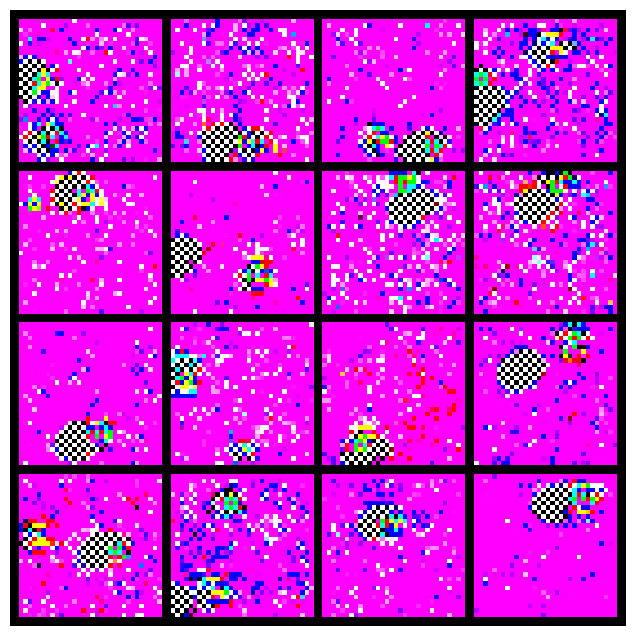

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

pipeline      = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32").to(device)
unet          = pipeline.unet.to(device)
scheduler     = pipeline.scheduler
discr = TimeCondDiscriminator(ngpu=1).to(device)
discr.load_state_dict(torch.load("discr_trained_5.pth"))



samples = guided_ddpm_sample(unet, discr, scheduler, num_images=16)

# Rescale from [-1, 1] to [0, 1]
samples = samples.clamp(-1, 1)
samples = (samples + 1) / 2.0

# Make grid and plot
grid = make_grid(samples, nrow=4)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()